# Calculation of Energy Production Capacities of Renewable Energy Sources
In this notebook we explain our approach to generate the energy production
capacities of renewable energy sources.  
We mostly follow the approach of [Saber et al.](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/iet-gtd.2014.0040).  


**Disclaimer:**
In this notebook we use Python, instead of Julia, because we are more familiar with its plotting capabilities.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## Wind Turbines

To generate the capacities of wind turbine from wind speed Saber et al. use the following formula:
$$
p_w=
\begin{cases}
	0 & \text{if } v < v_{ci} \lor v > v_{co} \\
	P_r \cdot \frac{v - v_{ci}}{v_r - v_{ci}} & \text{if } v_{ci} \leq v \leq v_r \\
	P_r & \text{if } v_r \leq v \leq v_{co} \\
\end{cases}
$$
The variables are defined as follows:
 - $p_w$ is the power output of the wind turbine
 - $v$ is the wind speed
 - $v_{ci}$ is the cut-in wind speed (wind speed at which the wind turbine is started)
 - $v_{co}$ is the cut-out wind speed (wind speed at which the wind turbine is shut down)
 - $v_r$ is the rated wind speed (wind speed at which the wind turbine produces its rated power output)
 - $P_r$ is the rated power output of the wind turbine (maximum capacity)

Our implementation of this can be found in `../src/scenarios/assemble.jl` in the `get_wind_power_generation` function.

## Solar Power Plants
Saber et al. use the following formula to calculate the power output of a solar power plant:
$$
\begin{split}
&P_s = N \cdot FF \cdot V_y \cdot I_y \\
&FF = \frac{V_{MPP} \cdot I_{MPP}}{V_{OC} \cdot I_{SC}} \\
&V_y = V_{OC} - k_V \cdot T_C \\
&I_y = s \cdot (I_{SC} + k_C \cdot (T_C - 25)) \\ 
&T_C = T_A + s \cdot \frac{T_N-20}{0.8} \\
\end{split}
$$
The variables are defined as follows:
- $P_s$ is the power output of the solar power plant (in $W$)
- $N$ is the number of cells in the solar power plant
- $FF$ is the fill factor 
- $V_{MPP}$ is the voltage at the maximum power point (in $V$)
- $I_{MPP}$ is the current at the maximum power point (in $A$)
- $V_{OC}$ is the open circuit voltage (in $V$)
- $I_{SC}$ is the short circuit current (in $A$)
- $k_V$ is the temperature coefficient of the voltage (in $V/\degree C$)
- $k_C$ is the temperature coefficient of the current (in $A/\degree C$)
- $T_A$ is the ambient temperature (in $\degree C$)
- $T_N$ is the nominal temperature (in $\degree C$)
- $T_C$ is the cell temperature (in $\degree C$)

The function is implemented below with reasonable values for the parameters.
In addition we implemented a linear approximation of the formula, that simply outputs the maximum capacity when solar irradiance is 1 and no capacity when solar irradiance is 0.

In [6]:
T_a = 25 # C
T_n = 34 # C

k_c = 0.0015 # A/C
k_v = 0.088 # V/C

V_mpp = 17.4 # V
I_mpp = 3.05 # A
V_oc = 21.0 # V
I_sc = 3.4 # A

N = 1 # number of cells

def pv_power_generation(s: float) -> float:
	T_c = T_a + s * (T_n - 20) / 0.8
	I_y = s * (I_sc + k_c * (T_c - 25))
	V_y = V_oc - k_v*T_c
	FF = (V_mpp * I_mpp) / (V_oc * I_sc)

	P_s = N * FF * V_y * I_y

	return P_s


P_max = pv_power_generation(1.0)
def approx_pv_power_generation(s: float) -> float:
	return s * P_max

Now we will compare the two functions for different values of the solar irradiance.

In [7]:
ss = np.linspace(0, 1, 100)

ps = [pv_power_generation(s) for s in ss]
approx_ps = [approx_pv_power_generation(s) for s in ss]

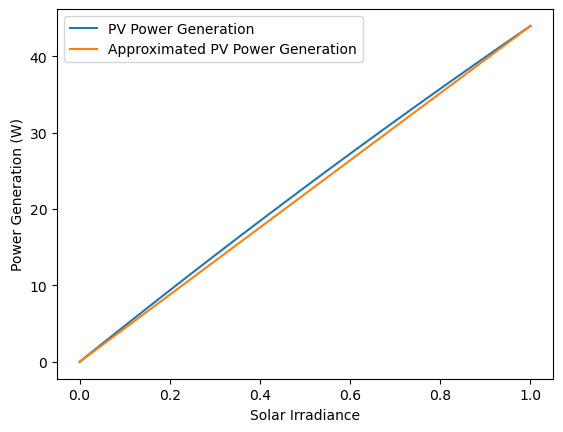

In [8]:
fig, ax = plt.subplots()

ax.plot(ss, ps, label="PV Power Generation")
ax.plot(ss, approx_ps, label="Approximated PV Power Generation")
ax.set_xlabel("Solar Irradiance")
ax.set_ylabel("Power Generation (W)")
ax.legend()

plt.savefig("../figures/pv_power_generation_approximation.png")

plt.show()

As we can see, the approximation is quite good and therefore we use it in our model.  
The implemenation can be found in `../src/scenarios/assemble.jl`.